In [77]:
import tensorflow as tf 
from keras import backend as K
from glob import glob
import pydicom
from keras import backend as K
from keras.optimizers import SGD
from keras.models import load_model, Model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.models import Sequential
import cv2
from scipy.ndimage import zoom
from sklearn import preprocessing
import pandas as pd
import math
import numpy as np
import re

In [78]:
def extract_number_from_path(path):
    match = re.search(r'(\d+)\.dcm$', path)
    if match:
        return int(match.group(1))
    return 0

def get_data_for_3d_volumes(data,train_data_cat, path, number_idx):
    
    data_to_merge = data[["patient_id", "series_id"]]
    patient_category = train_data_cat[["patient_id", "any_injury"]]
    
    merged_df = data_to_merge.merge(patient_category, on='patient_id', how='left')
    
    shuffled_data = merged_df.sample(frac=1, random_state=42)
    shuffled_indexes = shuffled_data.index[:number_idx]
    selected_rows = shuffled_data.loc[shuffled_indexes]
    data_to_merge_processed = selected_rows.reset_index()
    
    total_paths = []
    patient_ids = []
    series_ids = []
    category = []
    
    for patient_id in range(len(data_to_merge_processed)):
    
        p_id = str(data_to_merge_processed["patient_id"][patient_id]) + "/" + str(data_to_merge_processed["series_id"][patient_id])
        str_imgs_path = path + p_id + '/'
        patient_img_paths = []

        for file in glob(str_imgs_path + '/*'):
            patient_img_paths.append(file)
        
        
        sorted_file_paths = sorted(patient_img_paths, key=extract_number_from_path)
        total_paths.append(sorted_file_paths)
        patient_ids.append(data_to_merge_processed["patient_id"][patient_id])
        series_ids.append(data_to_merge_processed["series_id"][patient_id])
        category.append(data_to_merge_processed["any_injury"][patient_id])
    
    final_data = pd.DataFrame(list(zip(patient_ids, series_ids, total_paths, category)),
               columns =["Patient_id","Series_id", "Patient_paths", "Patient_category"])
    
    return final_data

In [79]:
train_data = pd.read_csv(f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
cat_data = pd.read_csv(f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
path = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
cleaned_df = get_data_for_3d_volumes(train_data, cat_data, path=path, number_idx=100)

In [80]:
cleaned_df.head()

,Patient_id,Series_id,Patient_paths,Patient_category
0,25102,50875,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,1
1,31158,28163,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
2,51177,42398,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
3,56046,38794,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
4,56400,12546,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0


In [81]:
"""
class Image3DGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, target_depth=64, target_size=(128,128)):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.target_depth = target_depth

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def standardize_pixel_array(self, dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        return pixel_array

    
    def resize_img(self, img_paths):
        preprocessed_images = []
        for image_path in img_paths: 
            image = pydicom.read_file(image_path)
            image = self.standardize_pixel_array(image)
            image = cv2.resize(image, self.target_size)
            image_array = np.array(image)
            preprocessed_images.append(image_array)

    # Create an empty volume array
        volume_shape = (self.target_size[0], self.target_size[1], len(preprocessed_images)) 
        volume = np.zeros(volume_shape, dtype=np.uint16)
    # Populate the volume with images
        for i, image_array in enumerate(preprocessed_images):
            volume[:,:,i] = image_array
        return volume
    
    def change_depth_siz(self, patient_volume):
        desired_depth = self.target_depth
        current_depth = patient_volume.shape[-1]
        depth = current_depth / desired_depth
        depth_factor = 1 / depth
        img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
        return img_new
    
    def normalize_volume(self, resized_volume):
        original_shape = resized_volume.shape
        flattened_image = resized_volume.reshape((-1,))
        scaler = preprocessing.MinMaxScaler()
        normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
        normalized_volume_image = normalized_flattened_image.reshape(original_shape)
        return normalized_volume_image
    
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        resized_images = []
        for list_files in batch_x:
            preprocessed_images = self.resize_img(list_files)
            resized_images_siz = self.change_depth_siz(preprocessed_images)
            normalized_volume = self.normalize_volume(resized_images_siz)
            resized_images.append(normalized_volume)

        resized_images = np.array(resized_images)
        return resized_images, np.array(batch_y)
"""

"\nclass Image3DGenerator(tf.keras.utils.Sequence):\n    def __init__(self, x_set, y_set, batch_size, target_depth=64, target_size=(128,128)):\n        self.x, self.y = x_set, y_set\n        self.batch_size = batch_size\n        self.target_size = target_size\n        self.target_depth = target_depth\n\n    def __len__(self):\n        return math.ceil(len(self.x) / self.batch_size)\n    \n    def standardize_pixel_array(self, dcm: pydicom.dataset.FileDataset) -> np.ndarray:\n    # Correct DICOM pixel_array if PixelRepresentation == 1.\n        pixel_array = dcm.pixel_array\n        if dcm.PixelRepresentation == 1:\n            bit_shift = dcm.BitsAllocated - dcm.BitsStored\n            dtype = pixel_array.dtype \n            pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift\n        return pixel_array\n\n    \n    def resize_img(self, img_paths):\n        preprocessed_images = []\n        for image_path in img_paths: \n            image = pydicom.read_file(image_path

In [82]:
class Image3DGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, target_depth=64, target_size=(128,128)):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.target_depth = target_depth

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def standardize_pixel_array(self, dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        return pixel_array

    
    def resize_img(self, img_paths):
        volume_shape = (self.target_size[0], self.target_size[1], len(img_paths)) 
        volume = np.zeros(volume_shape, dtype=np.float64)
        for i, image_path in enumerate(img_paths): 
            image = pydicom.read_file(image_path)
            image = self.standardize_pixel_array(image)
            image = cv2.resize(image, self.target_size)
            volume[:,:,i] = image
        return volume
    
    def change_depth_siz(self, patient_volume):
        current_depth = patient_volume.shape[-1]
        depth = current_depth / self.target_depth
        depth_factor = 1 / depth
        img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
        return img_new
    
    def normalize_volume(self, resized_volume):
        original_shape = resized_volume.shape
        flattened_image = resized_volume.reshape((-1,))
        scaler = preprocessing.MinMaxScaler()
        normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
        normalized_volume_image = normalized_flattened_image.reshape(original_shape)
        return normalized_volume_image
    
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        resized_shape = (len(batch_x), self.target_size[0], self.target_size[1], self.target_depth)
        resized_images = np.zeros(resized_shape, dtype=np.float64)
        for i, list_files in enumerate(batch_x):
            preprocessed_images = self.resize_img(list_files)
            resized_images_siz = self.change_depth_siz(preprocessed_images)
            normalized_volume = self.normalize_volume(resized_images_siz)
            resized_images[i,:,:,:] = normalized_volume
        return resized_images, np.array(batch_y)

In [83]:
data_gen = Image3DGenerator(cleaned_df["Patient_paths"], cleaned_df["Patient_category"], batch_size=4)

In [84]:
import time

start_time = time.perf_counter()
batch_x, batch_y = data_gen[0]
end_time = time.perf_counter()

duration = end_time - start_time
print(f"Batch iteration took {duration:.4f} seconds to execute.")

Batch iteration took 16.7791 seconds to execute.


In [85]:
batch_x.shape, batch_y.shape

((4, 128, 128, 64), (4,))

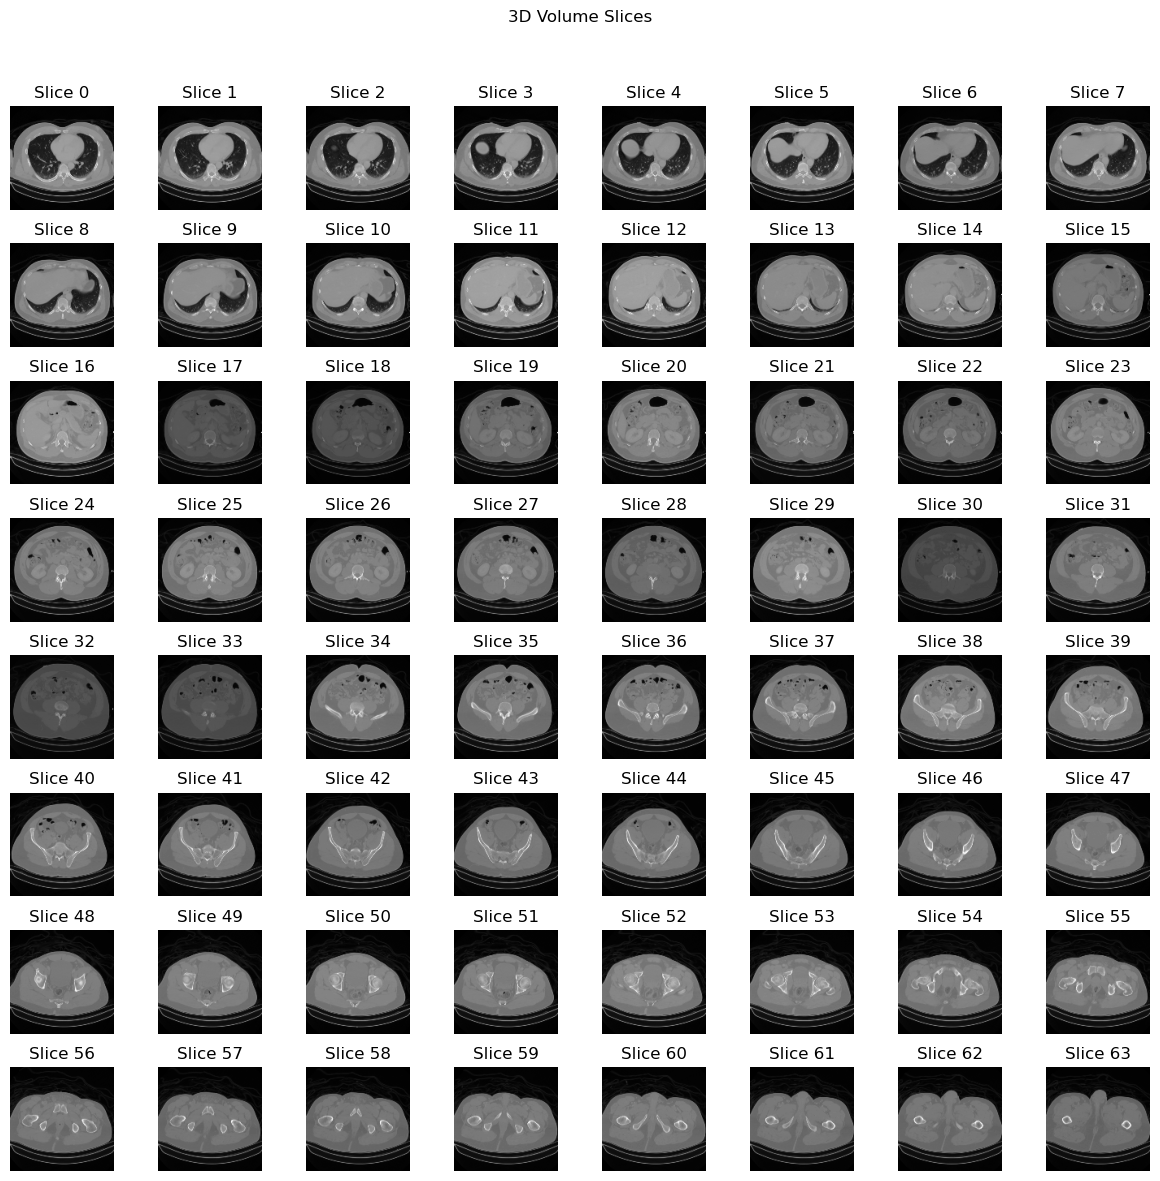

In [86]:
import matplotlib.pyplot as plt
# Create subplots
rows = 8  # Number of rows in the subplot grid
cols = 8  # Number of columns in the subplot grid
depth = 64

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle('3D Volume Slices')

for d in range(depth):
    row = d // cols
    col = d % cols
    
    ax = axes[row, col]
    ax.imshow(batch_x[2,:,:,d], cmap='gray')  # You can change the colormap if needed
    ax.set_title(f"Slice {d}")
    ax.axis('off')  # Turn off axis for cleaner visualization

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the position of the suptitle

# Show the plot
plt.show()